In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset
import experiments_utils

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [4]:
INPUT_PATH = "../../data/email-Eu-core-temporal.txt.gz"

Load the dataset

In [5]:
dataset = Dataset(INPUT_PATH, top=100, timescale='busca')
#dataset = Dataset.from_pickle(INPUT_PATH)

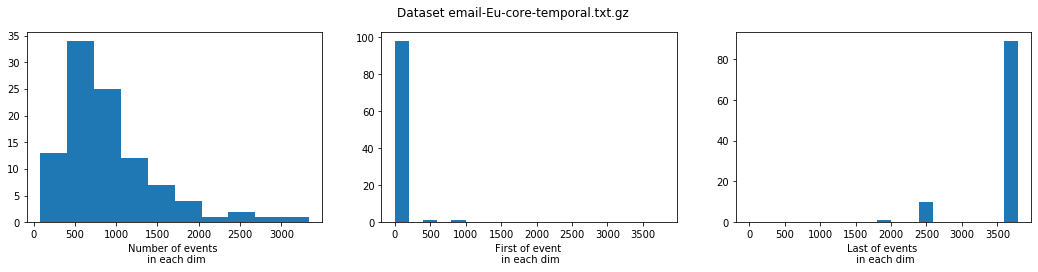

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)))
axs[0].set_xlabel('Number of events \n in each dim')

end_time = dataset.end_time
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}");

Print statistics of the dataset

In [7]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 92,924
               %NZ: 26.23%

Stats. of num. of events per dim:
count     100.000000
mean      929.240000
std       589.331261
min        82.000000
25%       544.000000
50%       770.000000
75%      1210.000000
max      3334.000000
dtype: float64


Build ground truth adjacency matrix

In [8]:
adjacency_true = nx.adjacency_matrix(dataset.graph, nodelist=range(dataset.dim)).toarray()
adjacency_true = adjacency_true / adjacency_true.max()

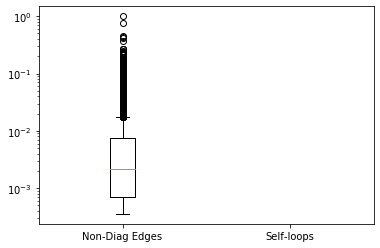

In [9]:
diag_mask = np.eye(len(adjacency_true)).astype(bool)
plt.boxplot([adjacency_true[~diag_mask & (adjacency_true > 0)], adjacency_true[diag_mask & (adjacency_true > 0)]],
            labels=['Non-Diag Edges', 'Self-loops']);
plt.yscale('log');

#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

Busca estimators of **beta_j**:
count    100.000000
mean       1.047905
std        1.697729
min        0.027075
25%        0.290726
50%        0.556137
75%        0.916652
max       13.946247
dtype: float64

Busca estimators of **beta_{ji}**:
count    10000.000000
mean         1.218551
std          2.322353
min          0.000000
25%          0.344177
50%          1.005101
75%          1.474181
max        118.583466
dtype: float64



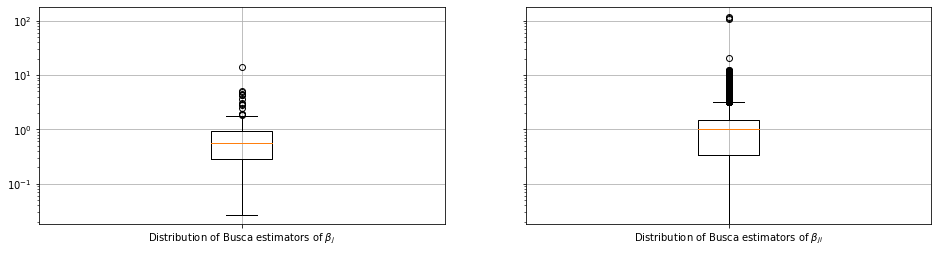

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) for ev in dataset.timestamps])
plt.sca(axs[0])
plt.grid()
plt.boxplot(busca_betas, labels=[r'Distribution of Busca estimators of $\beta_j$']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print()

wold_model = tsvar.models.WoldModel()
wold_model.observe(dataset.timestamps)
busca_beta_ji = np.zeros((wold_model.dim, wold_model.dim))
for i in range(wold_model.dim):
    busca_beta_ji[:, i] = np.median(wold_model.delta_ikj[i][:, :], axis=0) / np.exp(1)
del wold_model
plt.sca(axs[1])
plt.grid()
plt.boxplot(busca_beta_ji.flatten(), labels=[r'Distribution of Busca estimators of $\beta_{ji}$']);
plt.yscale('log')
print('Busca estimators of **beta_{ji}**:')
print(pd.Series(busca_beta_ji.flatten()).describe())
print()

In [11]:
events = dataset.timestamps
events = [np.sort(ev) for ev in events]
end_time = dataset.end_time

In [12]:
t0 = min(map(min, events))
t1 = max(map(max, events))

train_start = t0
train_end = t0 + (t1 - t0) * 0.5
test_end = t1 + 1e-5

train_events = [ev[(ev >= train_start) & (ev < train_end)] - train_start for ev in events]
test_events = [ev[(ev >= train_end) & (ev < test_end)] - train_end for ev in events]

print(sum(map(len, train_events)), sum(map(len, test_events)))

69911 23013


---

## Run inference

---

### Run VI

In [39]:
dim = len(train_events)

# Set priors
# prior: Alpha
as_pr = 1.0 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 100.0 * np.ones((dim, dim))
br_pr = 100.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(train_events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr[0,0] / ar_pr[0,0])
print('variance')
print(as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance')
print(br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
1.0
variance
1.0
BETA:
-----
mean
1.0101010101010102
variance
0.010411265822521235


In [40]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariationalOther(verbose=True)
vi_model.observe(train_events)

In [41]:
vi_res_dict = {}

for i in range(10):
    print('---> sim', i)
    
    # Set callback (parameters of callback are just the posterior mean of alpha)
    callback = tsvar.utils.callbacks.LearnerCallbackMLE(
        x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=100,
        coeffs_true=adjacency_true.flatten(),
        acc_thresh=0.05, dim=dim, 
        widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
        default_end='\n')
    
    # Fit model
    vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
              max_iter=100, tol=1e-3, callback=callback)
    
    # Extract adjacency mean
    vi_adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
    
    # Find suitable threshold for the scale of the data
    vi_adj_hat_flat = vi_adj_hat.flatten()
    thresh = vi_adj_hat_flat[np.argsort(vi_adj_hat_flat)[::-1][2600]]

    vi_res_dict[i] = experiments_utils.print_report(
        name=type(vi_model).__name__, adj_hat=vi_adj_hat, adj_true=adjacency_true, thresh=thresh);
    vi_res_dict[i]['threshold'] = thresh

---> sim 0
iter:   100 | dx: +1.5899e-03 | f1-score: 0.00 | relerr: 6.36e+00 | p@5: 0.60 | p@10: 0.50 | p@20: 0.30 | time/it: 4.76e-01     

========== Method: WoldModelVariationalOther

Accuracy: 0.64

Edge counts
------------
Pred: 2600.00
True: 2623.00

Error counts
------------
 True Positive: 825.00
False Positive: 1775.00
 True Negative: 5602.00
False Negative: 1798.00

Error rates
-----------
 True Positive Rate: 0.31
False Positive Rate: 0.24
 True Negative Rate: 0.76
False Negative Rate: 0.69

F-Score
-------
 F1-Score: 0.32
Precision: 0.32
   Recall: 0.31
   PR-AUC: 0.31
  ROC-AUC: 0.57

Precision@k
-----------
 Prec@10: 0.50
 Prec@50: 0.38
Prec@200: 0.40

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.12525252525252517
10 0.20505050505050498
20 0.29797979797979796
50 0.33252525252525256
100 0.26494949494949493
200 0.13247474747474747

---> sim 1
iter:   100 | dx: +1.5899e-03 | f1-score: 0.00 | relerr: 6.36e+00 | p@5: 0.60 | p@10: 0.50 | p@2

---> sim 9
iter:   100 | dx: +1.5899e-03 | f1-score: 0.00 | relerr: 6.36e+00 | p@5: 0.60 | p@10: 0.50 | p@20: 0.30 | time/it: 5.04e-01     

========== Method: WoldModelVariationalOther

Accuracy: 0.64

Edge counts
------------
Pred: 2600.00
True: 2623.00

Error counts
------------
 True Positive: 825.00
False Positive: 1775.00
 True Negative: 5602.00
False Negative: 1798.00

Error rates
-----------
 True Positive Rate: 0.31
False Positive Rate: 0.24
 True Negative Rate: 0.76
False Negative Rate: 0.69

F-Score
-------
 F1-Score: 0.32
Precision: 0.32
   Recall: 0.31
   PR-AUC: 0.31
  ROC-AUC: 0.57

Precision@k
-----------
 Prec@10: 0.50
 Prec@50: 0.38
Prec@200: 0.40

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.12525252525252517
10 0.20505050505050498
20 0.29797979797979796
50 0.33252525252525256
100 0.26494949494949493
200 0.13247474747474747



In [81]:
vi_res_df = pd.DataFrame(vi_res_dict).T
pd.DataFrame([vi_res_df.mean().round(2), vi_res_df.std()], index=['mean', 'std'])

,accuracy,precision,recall,f1score,prec@5,prec@10,prec@20,prec@50,prec@100,prec@200,tp,fp,tn,fn,tpr,fpr,tnr,fnr,threshold
mean,0.66,0.35,0.34,0.34,0.4,0.4,0.45,0.4,0.45,4.700000e-01,900.0,1700.0,5677.0,1723.0,0.34,2.300000e-01,0.77,0.66,0.01
std,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.00,6.206335e-17,0.0,0.0,0.0,0.0,0.00,3.103168e-17,0.00,0.00,0.00


In [20]:
mu_hat = vi_model._as_po[0, :] / vi_model._ar_po[0, :]
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
#adj_hat = (vi_model._as_po[1:, :] >= 1) * (vi_model._as_po[1:, :] - 1) / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1
model_name = type(vi_model).__name__

#adj_hat = adj_hat
adj_hat = adj_hat #/ beta_hat

#diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
#adjacency_true_zero_diag = adjacency_true.copy()
#adjacency_true_zero_diag[diag_mask] = 0
#adj_hat[diag_mask] = 0

vi_adj_hat_flat = adj_hat.flatten()
thresh = vi_adj_hat_flat[np.argsort(vi_adj_hat_flat)[::-1][2600]]
print(thresh)

experiments_utils.print_report(name=type(vi_model).__name__, adj_hat=adj_hat, adj_true=adjacency_true, thresh=thresh);

7.941900645504484e-05

========== Method: WoldModelVariationalOther

Accuracy: 0.59

Edge counts
------------
Pred: 2600.00
True: 2623.00

Error counts
------------
 True Positive: 570.00
False Positive: 2030.00
 True Negative: 5347.00
False Negative: 2053.00

Error rates
-----------
 True Positive Rate: 0.22
False Positive Rate: 0.28
 True Negative Rate: 0.72
False Negative Rate: 0.78

F-Score
-------
 F1-Score: 0.22
Precision: 0.22
   Recall: 0.22
   PR-AUC: 0.24
  ROC-AUC: 0.43

Precision@k
-----------
 Prec@10: 0.50
 Prec@50: 0.32
Prec@200: 0.38

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.0666666666666667
10 0.11919191919191906
20 0.19090909090909092
50 0.2707070707070706
100 0.26494949494949493
200 0.13247474747474747



In [26]:
test_dims = np.array([len(ev) > 0 for ev in test_events])
num_test_events = sum(map(len, test_events))
test_events_filtered = np.array(test_events)[test_dims].tolist()
test_model = tsvar.models.WoldModelOther()
test_model.observe(test_events_filtered)

def compute_vi_log_likelihoods(vi_model, num_samples=10):
    vals = list()
    adj_list = list()
    for i in range(num_samples):
        as_po = vi_model._as_po[np.hstack([[True], test_dims]), :][:, test_dims]
        ar_po = vi_model._ar_po[np.hstack([[True], test_dims]), :][:, test_dims]
        bs_po = vi_model._bs_po[test_dims, :][:, test_dims]
        br_po = vi_model._br_po[test_dims, :][:, test_dims]

        alpha_sample = np.random.gamma(shape=as_po, scale=1/ar_po)
        beta_sample = np.random.gamma(shape=bs_po, scale=1/br_po)
        coeffs = torch.tensor(np.hstack((
            alpha_sample[0, :].flatten(), beta_sample.flatten(), alpha_sample[1:, :].flatten()
        )))
        ll = test_model.log_likelihood(coeffs) / num_test_events
        vals.append(ll)
        adj_list.append(np.random.gamma(shape=vi_model._as_po, scale=1/vi_model._ar_po)[1:, :])
    print(f"{np.mean(vals):.2f} ($\pm {np.std(vals):.2e}$)")
    return vals, adj_list

In [27]:
vals, vi_adj_list = compute_vi_log_likelihoods(vi_model, num_samples=10)

-3.49 ($\pm 4.85e-03$)


---

### Run GB

In [23]:
import gb
import time

dim = len(train_events)

gb_res_list = list()

for dir_prior in [10.0]:
    print('='*10, dir_prior)

    for i in range(5):
        print('---> sim', i)

        # Define model
        granger_model = gb.GrangerBusca(
            alpha_prior=dir_prior,
            num_iter=3000,
            metropolis=True,
            beta_strategy='busca',
            num_jobs=4,
        )
        granger_model.fit(train_events)

        # Extract adjacency
        gb_adj_hat = granger_model.Alpha_.toarray()
        gb_adj_hat = gb_adj_hat / gb_adj_hat.sum(axis=1)[:, None]

            # Find suitable threshold for the scale of the data
        gb_adj_hat_flat = gb_adj_hat.flatten()
        thresh = gb_adj_hat_flat[np.argsort(gb_adj_hat_flat)[::-1][2600]]

        gb_res_dict = experiments_utils.print_report(
            name=type(granger_model).__name__, adj_hat=gb_adj_hat, adj_true=adjacency_true, thresh=thresh);
        gb_res_dict['threshold'] = thresh
        gb_res_dict['prior'] = dir_prior
        gb_res_list.append(gb_res_dict)

========== 10.0
---> sim 0

========== Method: GrangerBusca

Accuracy: 0.64

Edge counts
------------
Pred: 2595.00
True: 2623.00

Error counts
------------
 True Positive: 828.00
False Positive: 1767.00
 True Negative: 5610.00
False Negative: 1795.00

Error rates
-----------
 True Positive Rate: 0.32
False Positive Rate: 0.24
 True Negative Rate: 0.76
False Negative Rate: 0.68

F-Score
-------
 F1-Score: 0.32
Precision: 0.32
   Recall: 0.32
   PR-AUC: 0.31
  ROC-AUC: 0.57

Precision@k
-----------
 Prec@10: 0.20
 Prec@50: 0.32
Prec@200: 0.38

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.11313131313131308
10 0.18888888888888877
20 0.2681818181818182
50 0.3432323232323231
100 0.26494949494949493
200 0.13247474747474747

---> sim 1

========== Method: GrangerBusca

Accuracy: 0.65

Edge counts
------------
Pred: 2599.00
True: 2623.00

Error counts
------------
 True Positive: 841.00
False Positive: 1758.00
 True Negative: 5619.00
False Negative: 1782.00

In [24]:
gb_res_df = pd.DataFrame(gb_res_list)
gb_res_df.groupby('prior').agg(['mean', 'std'])[['f1score', 'prec@10', 'prec@50', 'prec@200', 'pr_auc', 'roc_auc']].round(2)

f1score      prec@10      prec@50       prec@200       pr_auc       \
         mean  std    mean  std    mean   std     mean   std   mean  std   
prior                                                                      
10.0     0.32  0.0     0.2  0.0    0.34  0.02     0.44  0.04   0.32  0.0   

      roc_auc       
         mean  std  
prior               
10.0     0.57  0.0

In [101]:
gb_res_df = pd.DataFrame(gb_res_list)
gb_res_df.groupby('prior').agg(['mean', 'std'])[['f1score', 'prec@10', 'prec@50', 'prec@200', 'pr_auc', 'roc_auc']].round(2)

f1score       prec@10       prec@50       prec@200      
           mean   std    mean   std    mean   std     mean   std
prior                                                           
0.01       0.09  0.00    0.06  0.05    0.04  0.01     0.27  0.02
0.10       0.26  0.01    0.10  0.00    0.04  0.01     0.29  0.03
1.00       0.32  0.01    0.20  0.00    0.04  0.00     0.29  0.03
10.00      0.32  0.01    0.20  0.00    0.35  0.07     0.43  0.03
100.00     0.30  0.01    0.28  0.08    0.36  0.03     0.33  0.02
1000.00    0.29  0.00    0.38  0.13    0.23  0.05     0.24  0.03

In [23]:
# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))
model_name = type(granger_model).__name__

adj_hat = adj_hat #/ beta_hat  # Does not matter

diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
adjacency_true_zero_diag = adjacency_true.copy()
adjacency_true_zero_diag[diag_mask] = 0
#adj_hat[diag_mask] = 0


THRESH = 0.00  # GB is already sparse

experiments_utils.print_report(name=model_name, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0)


========== Method: GrangerBusca

Accuracy: 0.26

Edge counts
------------
Pred: 509.00
True: 2623.00

Error counts
------------
 True Positive: 156.00
False Positive: 353.00
 True Negative: 7024.00
False Negative: 2467.00

Error rates
-----------
 True Positive Rate: 0.06
False Positive Rate: 0.05
 True Negative Rate: 0.95
False Negative Rate: 0.94

F-Score
-------
 F1-Score: 0.10
Precision: 0.31
   Recall: 0.06

Precision@k
-----------
 Prec@10: 0.10
 Prec@50: 0.04
Prec@200: 0.29

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.25656565656565633
10 0.2717171717171716
20 0.19292929292929295
50 0.0999999999999999
100 0.05030303030303025
200 0.025151515151515126



In [102]:
import gb

test_dims = np.array([len(ev) > 0 for ev in test_events])
num_test_events = sum(map(len, test_events))
test_events_filtered = np.array(test_events)[test_dims].tolist()
test_model = tsvar.models.WoldModelOther()
test_model.observe(test_events_filtered)

def compute_gb_log_likelihoods(num_samples=10):
    vals = list()
    for i in range(num_samples):
        print(f'\r{i}', end='')
        # Define model
        granger_model = gb.GrangerBusca(
            alpha_prior=10.00,
            num_iter=300,
            metropolis=True,
            beta_strategy='busca',
            num_jobs=10,
        )

        # Fit the model
        granger_model.fit(events)

        # Extract estimate of parameters
        mu_hat = granger_model.mu_[test_dims]
        adj_hat = granger_model.Alpha_.toarray()[test_dims, :][:, test_dims]
        adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
        dim = len(events)
        beta_hat = np.ones((dim, dim)) * granger_model.beta_
        beta_hat = beta_hat[test_dims, :][:, test_dims]
        coeffs_hat = torch.tensor(np.hstack((
            mu_hat, beta_hat.flatten(), adj_hat.flatten()
        )))
        
        ll = test_model.log_likelihood(coeffs_hat) / num_test_events
        vals.append(ll)
    print('\r', end='')
    print(f"{np.mean(vals):.2f} ($\pm {np.std(vals):.2e}$)")
    return vals

In [103]:
compute_gb_log_likelihoods()

-4.31 ($\pm 8.81e-03$)


[tensor(-4.2978, dtype=torch.float64),
 tensor(-4.3184, dtype=torch.float64),
 tensor(-4.2967, dtype=torch.float64),
 tensor(-4.3107, dtype=torch.float64),
 tensor(-4.3136, dtype=torch.float64),
 tensor(-4.3168, dtype=torch.float64),
 tensor(-4.2915, dtype=torch.float64),
 tensor(-4.3048, dtype=torch.float64),
 tensor(-4.3144, dtype=torch.float64),
 tensor(-4.3070, dtype=torch.float64)]